# Creating a training dataset for training Generative Adversarial Networks for emulating GW Flow Simulations

In [1]:
# import 
import numpy as np
import matplotlib.pyplot as plt

# import from package 'geone'
from geone import img
import geone.imgplot as imgplt
import geone.deesseinterface as dsi
from geone.deesse_core.deesse import MPDS_MISSING_VALUE # constant for missing value

# import flopy stuff
import flopy.utils.binaryfile as bf

# import the custom functions
from func import forward256 as forward
import os
from func import progressBar
from func import sampleHeads

In [2]:
# Read the TI (Img Class)
ti_filename = 'data/ti_strebelle_K.gslib' # strebelle with K values
ti = img.readImageGslib(ti_filename, missing_value=MPDS_MISSING_VALUE)

(<AxesSubplot:title={'center':'TI'}>,
 <matplotlib.colorbar.Colorbar at 0x7f26c9544550>)

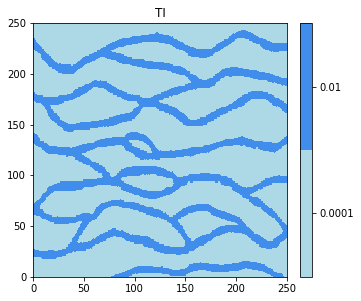

In [3]:
col = ['lightblue', [x/255. for x in ( 65, 141, 235)], 'orange']

plt.figure(figsize=(5,5))
imgplt.drawImage2D(ti, categ=True, categCol=col, title='TI')


##  Set up the DS parameters


In [4]:
# Set input for deesse
# --------------------
# DeeSse input parameters to create the true K field
deesse_input_true = dsi.DeesseInput(
    nx=256,ny=256,nz=1,nv=1,varname='facies',
    nTI=1,TI=ti,
    searchNeighborhoodParameters=dsi.SearchNeighborhoodParameters(rx=40.,ry=40.),
    nneighboringNode=50,
    distanceThreshold=0.02,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=14,
    nrealization=1)


In [5]:
# DeeSse input parameters to create the realisations for training the ML
deesse_input_realisations = dsi.DeesseInput(
    nx=256,ny=256,nz=1,nv=1,varname='facies',
    nTI=1,TI=ti,
    searchNeighborhoodParameters=dsi.SearchNeighborhoodParameters(rx=40.,ry=40.),
    nneighboringNode=50,
    distanceThreshold=0.02,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=10)

##  Reference parameter field


DeeSse running... [VERSION 3.2 / BUILD NUMBER 20210930 / OpenMP 43 thread(s)]
* checking out license OK.
DeeSse run complete


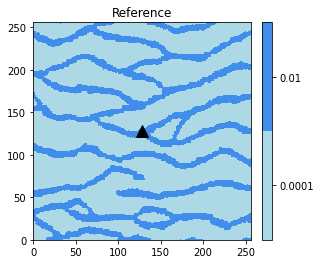

In [6]:
# create the candidate true K field realisations to choose as the ground truth
# well location
wpt = 128,128 # Well location
# perform the DS simulation to create the reference K field
trueKList = dsi.deesseRun(deesse_input_true)
trueK     = trueKList["sim"]
trueK     = img.gatherImages(trueK,varInd=0)
# plot the created reference image
imgplt.drawImage2D(trueK,categCol=col,categ=True,title="Reference")
plt.plot(wpt[0],wpt[1],'k^:',markersize=12)
# write the reference as a GSLIB file
img.writeImageGslib(trueK,filename= ("results/GSLIB/256_256_non-cond/trueK.gslib"))


##  Perform the MPS Simulations 


In [7]:
# Do DS simulations to create 
# --------------------
doSimul=True

if doSimul:
    simKList  = dsi.deesseRun(deesse_input_realisations)
    simK      = simKList["sim"]
    simK      = img.gatherImages(simK)
    img.writeImageGslib(simK,filename= ("results/GSLIB/256_256_non-cond/simKAll.gslib"))

    # Write the simulations in seperate GSLIB files
    for i in range(simK.val.shape[0]):
        temp_simK = img.copyImg(simK)
        temp_simK.remove_allvar()
        temp_simK.append_var(simK.val[i,:,:,:])
        img.writeImageGslib(temp_simK,
                            filename="results/GSLIB/256_256_non-cond/realisations/real_%05.d.gslib" % i)
else:
    # Import the fields
    trueK_filename = 'results/GSLIB/256*256_non-cond/trueK.gslib'
    simK_filename  = 'results/GSLIB/256*256_non-cond/simKAll.gslib'
    trueK = img.readImageGslib(trueK_filename, missing_value=MPDS_MISSING_VALUE)
    simK  = img.readImageGslib(simK_filename, missing_value=MPDS_MISSING_VALUE)


DeeSse running... [VERSION 3.2 / BUILD NUMBER 20210930 / OpenMP 43 thread(s)]
* checking out license OK.
DeeSse run complete


##  Perform flow Simulations and Save 


In [8]:
if doSimul:
    mf_trueK=forward.Modflow()
    # flow simulation for the reference parmater field
    flow_trueK = img.copyImg(trueK)
    flow_trueK.remove_allvar()
    predTrueK=mf_trueK.predict(model=trueK,imod=0,modelName="forwTrueK")
    flow_trueK.append_var(predTrueK[0])
    img.writeImageGslib(flow_trueK,filename="results/GSLIB/256_256_non-cond/flow_trueK.gslib" )

    mf_simK=forward.Modflow()
    # flow simulations for realisations
    for i in range(simK.val.shape[0]):
        flow_simK = img.copyImg(simK)
        flow_simK.remove_allvar()
        predSimK=mf_simK.predict(model=simK,imod=i,modelName="forwSimK")
        flow_simK.append_var(predSimK[0])
        img.writeImageGslib(flow_simK,
                            filename="results/GSLIB/256_256_non-cond/flowRealisations/flow_%05.d.gslib" % i)
        progressBar.update_progress(i / simK.val.shape[0])
else:
    flow_trueK_filename = 'results/GSLIB/256_256_non-cond/flow_trueK.gslib'
    flow_simK_filename  = 'results/GSLIB/256_256_non-cond/simKAll.gslib'
    flow_trueK = img.readImageGslib(flow_trueK_filename, missing_value=MPDS_MISSING_VALUE)
    flow_simK  = img.readImageGslib(flow_simK_filename, missing_value=MPDS_MISSING_VALUE)



Progress: [###########################---] 90.0%


##  Display the parameter fields 


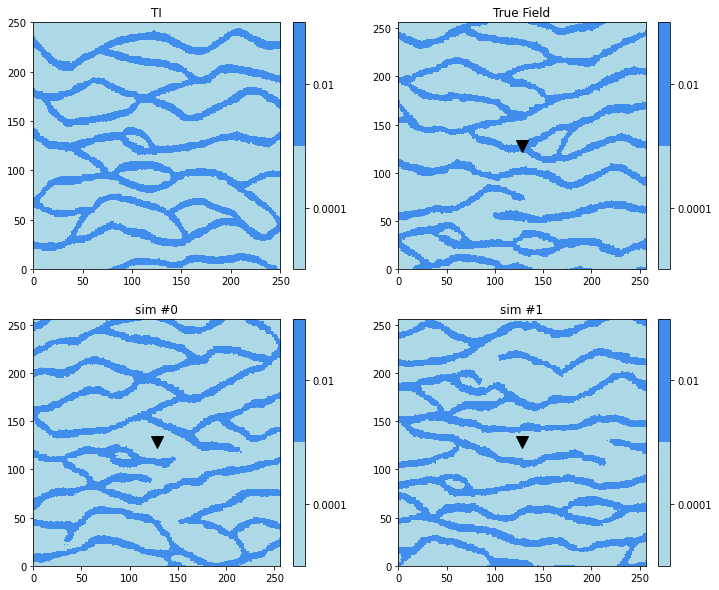

In [9]:
# Draw TI
fig, ax = plt.subplots(2, 2, figsize=(12,10))
plt.subplot(2, 2, 1)
imgplt.drawImage2D(ti,
                   categ=True, categCol=col,
                   title='TI')

plt.subplot(2, 2, 2)
imgplt.drawImage2D(trueK,iv=0,
                   categ=True,  categCol=col,
                   title='True Field')
plt.plot(wpt[0],wpt[1],'v',markersize=12, color="black")
# plt.plot(headsInd[:,0],headsInd[:,1],'.',markersize=14, color="black")


for i in list(range(2)) :
    plt.subplot(2, 2, i+3)
    imgplt.drawImage2D(simK,iv=i,
                       categ=True,  categCol=col,
                       title='sim #{}'.format(i))
    plt.plot(wpt[0],wpt[1],'v',markersize=12, color="black")
    # plt.plot(headsInd[:,0],headsInd[:,1],'.',markersize=14, color="black")
plt.savefig('results/plots/TI_and_realisations.png')


##  Display the Flow Simulations 
- Please note that the orientation of geon package and modflow differ


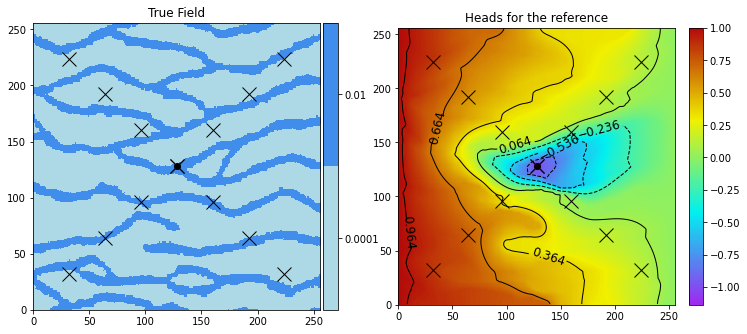

In [10]:
obsLoc=sampleHeads.sample(trueK,spacing=32)+1

fig_flow, ax = plt.subplots(2, 2, figsize=(12,10))
plt.subplot(1, 2, 1, aspect='equal')
hds = bf.HeadFile(mf_trueK.model_ws+"/"+ mf_trueK.modelname + '.hds')
head = hds.get_data(totim=1.0)
levelsDefine = np.arange(np.min(head),np.max(head),0.3)
extent = (mf_trueK.delr / 2, mf_trueK.Lx - mf_trueK.delr / 2, 
          mf_trueK.Ly - mf_trueK.delc / 2, mf_trueK.delc / 2)
plt.plot(obsLoc[:,0],obsLoc[:,1],'x',markersize=14, color="black")

imgplt.drawImage2D(trueK,iv=0,
                   categ=True,  categCol=col,
                   title='True Field', colorbar_pad_fraction=0.2)
plt.plot(wpt[0],wpt[1],'o',markersize=6, color="black")
# plt.contour(head[0, ::-1, :], levels=levelsDefine, extent=extent)


plt.subplot(1, 2, 2, aspect='equal')
trueKSim=img.readImageGslib(filename="results/GSLIB/256_256_non-cond/flow_trueK.gslib" )

imgplt.drawImage2D(trueKSim,
                   categ=False,
                   title='Heads for the reference'.format(i))
plt.plot(wpt[0],wpt[1],'o',markersize=6, color="black")
cs=plt.contour(head[0, ::-1, :], levels=levelsDefine, extent=extent,linewidths=1, colors='k')
plt.clabel(cs,inline=-1, fontsize=12)
plt.plot(obsLoc[:,0],obsLoc[:,1],'x',markersize=14, color="black")
plt.savefig('results/plots/flow_simulations_trueK_new.png')

##  Display more flow simulations

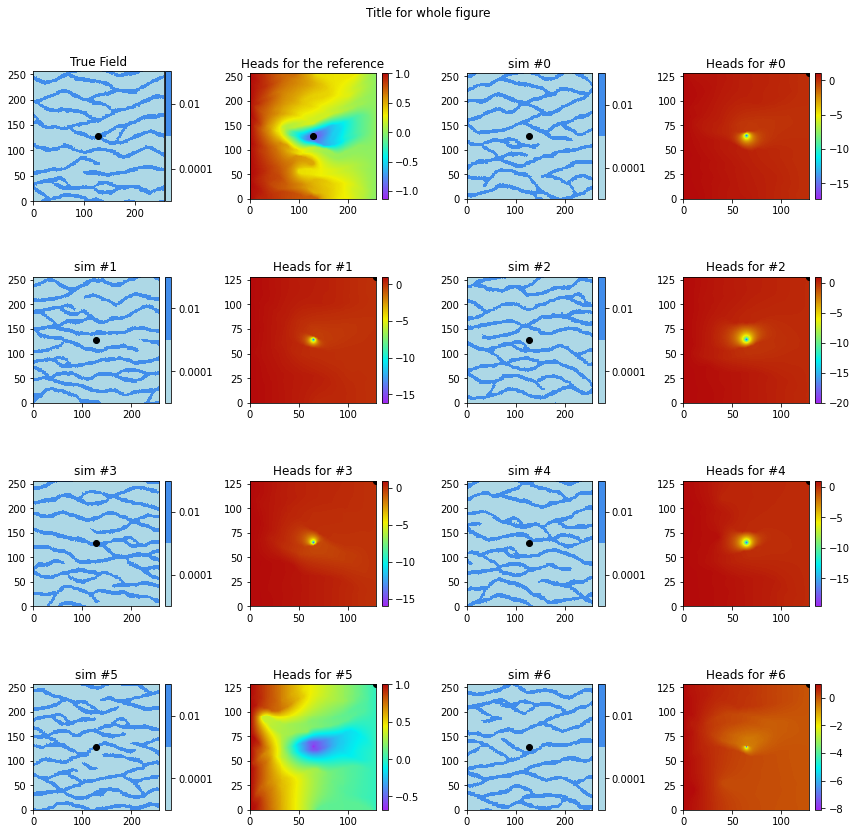

In [11]:
nrowIm =4
ncolIm =4


levelsDefine = np.arange(np.min(head),np.max(head),0.4)

fig_reals, ax = plt.subplots(6, 6, figsize=(12,12))
fig_reals.suptitle("Title for whole figure\n")
plt.subplot(nrowIm, ncolIm, 1, aspect='equal')
imgplt.drawImage2D(trueK,iv=0,
                   categ=True,  categCol=col,
                   title='True Field', colorbar_pad_fraction=0.2)
plt.plot(wpt[0],wpt[1],'o',markersize=6, color="black")

plt.subplot(nrowIm, ncolIm, 2, aspect='equal')
imgplt.drawImage2D(trueKSim,
                   categ=False,
                   title='Heads for the reference'.format(i))
plt.plot(wpt[0],wpt[1],'o',markersize=6, color="black")



for i in range(7):
    plt.subplot(nrowIm, ncolIm, 2*i+3, aspect='equal')
    imgplt.drawImage2D(simK,iv=i,
                       categ=True,  categCol=col,
                       title='sim #{}'.format(i))
    plt.plot(wpt[0],wpt[1],'o',markersize=6, color="black")
    # plt.plot(headsInd[:,0],headsInd[:,1],'.',markersize=5, color="black")

    #plt.plot(wpt[0],wpt[1],'k^:',markersize=12)
    plt.subplot(nrowIm, ncolIm, 2*i+4, aspect='equal')
    a=img.readImageGslib(filename="results/GSLIB/128_128_non-cond/flowRealisations/flow_%05.d.gslib" % i)
    # headsInd = a.sample(spacing=16) # get the index values for the measurement pts.

    imgplt.drawImage2D(a,
                       categ=False,
                       title='Heads for #{}'.format(i))
    plt.plot(wpt[0],wpt[1],'o',markersize=6, color="black")
    # plt.plot(headsInd[:,0],headsInd[:,1],'.',markersize=5, color="black")


    #a=plt.imshow(flowSim_reals[i][0, ::-1, :], origin="lower")
    #ccol.add_colorbar(a)
    #plt.title('Heads for #{}'.format(i) )
plt.tight_layout()    
plt.savefig('results/plots/flow_simulations_realisations_new.png')
